[link text](https://)# IFT6135-A2023
# Assignment 3: VAE Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `vae.py` and submit it on Gradescope.

Only edit the functions specified in the PDF (and wherever marked – `# WRITE CODE HERE`). Do not change definitions or edit the rest of the template, else the autograder will not work.

**Make sure you request a GPU runtime!**

## VAE Basics

Variational Autoencoders are generative latent-variable models that are popularly used for unsupervised learning and are aimed at maximizing the log-likelihood of the data, that is, maximizing $\sum\limits_{i=1}^N \log p(x_i; \theta)$ where $N$ is the number of data samples available. The generative story is as follows

\begin{align*}
  z &\sim \mathcal{N}(0, I) \\
  x | z &\sim \mathcal{N}(\mu_\theta(z), \Sigma_\theta(z))
\end{align*}

Given $\mu_\theta(\cdot)$ and $\Sigma_\theta(\cdot)$ are parameterized as arbitrary Neural Networks, one cannot obtain the log-likelihood $\log \mathbb{E}_{z}[p(x | z, \theta)]$ in closed form and hence has to rely on variational assumptions for optimization.

One way of optimizing for log-likelihood is to use the variational distribution $q_\phi(z | x)$, which with a little bit of algebra leads to the ELBO, which is

\begin{align*}
  ELBO = \sum_{i=1}^N \left( \mathbb{E}_{z\sim q_\phi(z|x_i)} [\log p_\theta(x_i | z)] + \mathbb{KL}[q_\phi(z|x_i) || \mathcal{N}(0, I)] \right)
\end{align*}

This is the objective that we use for optimizing VAEs, where different flavours of VAE can be obtained by changing either the approximate posterior $q_\phi$, the conditional likelihood distribution $p_\theta$ or even the standard normal prior.

The aim of this assignment would be to code a simple version of a VAE, where $q_\phi(z|x)$ will be parameterized as $\mathcal{N}(\mu_\phi(x), \Sigma_\phi(x))$ where $\mu(x)$ is a mean vector and $\Sigma(x)$ will be a **diagonal covariance matrix**, that is, it will only have non-zero entries on the diagonal.

The likelihood $p_\theta(x|z)$ will also be modeled as a Gaussian Distribution $\mathcal{N}(\mu_\theta(z), I)$ where we parameterize the mean with another neural network but for simplicity, consider the identity covariance matrix.

For details about VAEs, please refer to [Kingma's Paper](https://arxiv.org/abs/1312.6114) and the [Rezende's Paper](https://arxiv.org/abs/1401.4082)

In [1]:
!pip install -q -U datasets matplotlib tqdm

import random
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms

from pathlib import Path
from torch.utils.data import DataLoader

def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results_VAE_test")
results_folder.mkdir(exist_ok = True)
device = "cuda" if torch.cuda.is_available() else "cpu"

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


/home/simon/Documents/a2023/DL/assignment3/practical/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up the hyperparameters
- Batch Size
- Latent Dimensionality
- Learning Rate

In [2]:
# Training Hyperparameters
batch_size = 64   # Batch Size
z_dim = 32        # Latent Dimensionality
lr = 1e-4         # Learning Rate

In [3]:
# Define Dataset Statistics
image_size = 32
input_channels = 1

# Resize and Normalize the Data
transform = Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)]
)

# Helper Functions
def show_image(image, nrow=8):
  # Input: image
  # Displays the image using matplotlib
  grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

def transforms_examples(examples):
  # Helper function to perform transformations on the input images
  if "image" in examples:
    examples["pixel_values"] = [transform(image) for image in examples["image"]]
    del examples["image"]
  else:
    examples["pixel_values"] = [transform(image) for image in examples["img"]]
    del examples["img"]

  return examples

In [4]:
# Load dataset from the hub, normalize it and create the dataloader
def get_dataloaders():
  dataset = load_dataset("mnist", cache_dir='./data')
  transformed_dataset = dataset.with_transform(transforms_examples)
  train_dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True, drop_last=True)
  test_dataloader = DataLoader(transformed_dataset["test"], batch_size=batch_size, shuffle=False, drop_last=False)

  return train_dataloader, test_dataloader

## Visualize the Data

Let's visualize what our data actually looks like! We are using the [MNIST](https://huggingface.co/datasets/mnist). The MNIST dataset is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. Please note that you don't need to download dataset yourself as the code we provided download the dataset for you.

torch.Size([64, 1, 32, 32])


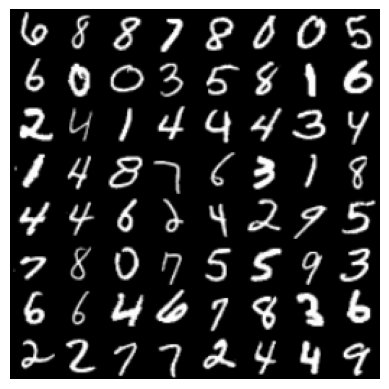

In [5]:
# Visualize the Dataset
def visualize():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  print(batch['pixel_values'].shape)

  save_image((batch['pixel_values'] + 1.) * 0.5, './results_VAE/orig.png')
  show_image((batch['pixel_values'] + 1.) * 0.5)

if __name__ == '__main__':
  visualize()

## Define the Model Architectures

For our VAE models, we use an encoder network and a decoder network, both of which have been pre-defined for ease of use in this assignment.

Encoder: It is a model that maps input images to the latent space, and in particular, to the parameters of the distribution in the latent space.

Decoder: It is a model that maps a sample in the latent space to a distribution in the observed space.

In [6]:
from vae_solution_test import Encoder, Decoder

# Diagonal Gaussian Distribution

The following class provides a way of setting up the diagonal gaussian distribution, which is parameterized by a mean vector, and a logvar vector of the same shape as the mean vector. The logvar vector denotes the log of the variances on the diagonals of a diagonal covariance matrix.

The task is to implement the following functions:

- Sampling: Provide the methodology of computing a **reparamterized** sample from the given distribution.
- KL Divergence: Compute and return the KL divergence of the distribution with the standard normal, that is, $\mathbb{KL}[\mathcal{N}(\mu, \Sigma) || \mathcal{N}(0, I)]$ where $\Sigma$ is a diagonal covariance matrix.
- Negative Log Likelihood: Given some data $x$, returns the log likelihood under the current gaussian, that is, $\log \mathcal{N}(x | \mu, \Sigma)$
- Mode: Returns the mode of the distribution

In [7]:
from vae_solution_test import DiagonalGaussianDistribution

# VAE Model

The Variational Autoencoder (VAE) model consists of an encoder network that parameterizes the distribution $q_\phi$ as a Diagonal Gaussian Distribution through the (mean, log variance) parameterization and a decoder network that parameterizes the distribution $p_\theta$ as another Diagonal Gaussian Distribution with an identity covariance matrix.

The task is to implement the following

- Encode: The function that takes as input a batched data sample, and returns the approximate posterior distribution $q_\phi$
- Decode: The function that takes as input a batched sample from the latent space, and returns the mode of the distribution $p_\theta$
- Sample: Generates a novel sample by sampling from the prior and then using the mode of the distribution $p_\theta$
- Forward: The main function for training. Given a data sample x, encode it using the encode function, and then obtain a reparameterized sample from it, and finally decode it. Return the mode from the decoded distribution $p_\theta$, as well as the conditional likelihood and KL terms of the loss. Note that the loss terms should be of size (batch size,) as the averaging is taken care of in the training loop
- Log Likelihood: The main function for testing that approximates the log-likelihood of the given data. It is computed using importance sampling as $\log \frac{1}{K} \sum\limits_{k=1}^K \frac{p_\theta(x, z_k)}{q_\phi(z_k|x)}$ where $z_k \sim q_\phi(z | x)$. Please compute this quantity using the log-sum-exp trick for more stable computations; you can use PyTorch's logsumexp() function.

In [8]:
from vae_solution import VAE

Here we define the model as well as the optimizer to take care of training.

In [9]:
if __name__ == '__main__':
  model = VAE(in_channels=input_channels,
            input_size=image_size,
            z_dim=z_dim,
            decoder_features=32,
            encoder_features=32,
            device=device
            )
  model.to(device)
  num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
  print("learnable parameters:", num_params)
  optimizer = Adam(model.parameters(), lr=lr)

learnable parameters: 1177057


In [10]:
epochs = 25
if __name__ == '__main__':
  train_dataloader, _ = get_dataloaders()
  for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
      model.train()
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")

        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        x = batch["pixel_values"].to(device)

        recon, nll, kl = model(x)
        loss = (nll + kl).mean()

        loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=loss.item())

    samples = model.sample(batch_size=64)
    save_image((x + 1.) * 0.5, './results_VAE/orig.png')
    save_image((recon + 1.) * 0.5, './results_VAE/recon.png')
    save_image((samples + 1.) * 0.5, f'./results_VAE_test/samples_{epoch}.png')

  show_image(((samples + 1.) * 0.5).clamp(0., 1.))

KeyboardInterrupt: 

Once the training of the model is done, we can use the model to approximate the log-likelihood of the test data using the function that we defined above.

In [ ]:
if __name__ == '__main__':
  _, test_dataloader = get_dataloaders()
  with torch.no_grad():
    with tqdm(test_dataloader, unit="batch", leave=True) as tepoch:
      model.eval()
      log_likelihood = 0.
      num_samples = 0.
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")
        batch_size = batch["pixel_values"].shape[0]
        x = batch["pixel_values"].to(device)

        log_likelihood += model.log_likelihood(x).sum()
        num_samples += batch_size
        tepoch.set_postfix(log_likelihood=log_likelihood / num_samples)

Finally, we also visualize the interpolation between two points in the latent space: $z_1$ and $z_2$ by choosing points at equal intervals on the line from the two points.

In [ ]:
from vae_solution_test import interpolate

if __name__ == '__main__':
  z_1 = torch.randn(1, z_dim).to(device)
  z_2 = torch.randn(1, z_dim).to(device)

  interp = interpolate(model, z_1, z_2, 10)
  show_image((interp + 1.) * 0.5, nrow=10)